In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
# Obrazok 28x28 ma spolu 784 px a tie budu vstupnou vrstvou (784 neuronov)
# Prvy skryty layer 128
# Druhy skryty layer 64
# na vystupe 10 neuronov (od 0-9)


In [4]:
trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True)

In [5]:
testset = datasets.MNIST("neuronove_siete_projekt",download=True,train=False)

In [6]:
print("trainset {}".format(len(trainset)))
print("testset {}".format(len(testset)))

trainset 60000
testset 10000


In [7]:
print(trainset[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7FF1799F3588>, 5)


In [8]:
trainset[0][0]

In [9]:
img = trainset[0][0]
img_data=img.getdata()
print("min: {}".format(min(img_data)))
print("max: {}".format(max(img_data)))

min: 0
max: 255


In [10]:
# trieda obrazku je nieco ine ako matica a preto ju treba transformovat
#transforms = transforms.Compose([
#    #konvertujem obrazok na Tensor
#    transforms.ToTensor(),
# ])


In [11]:
# prevediem hodnoty z 0-255 na hodnoty od 0-1
# trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True,transform=transforms)
# trainset[0][0]

In [12]:
# normalizujem si to a prevediem na interval -1až1
#konvertujem obrazok na Tensor
#mame šedé obrázky, tym padom nepotrebujem v poliach udavat RGB
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.double())
])
testset = datasets.MNIST("neuronove_siete_projekt",download=True,train=False,transform=transforms)
trainset = datasets.MNIST("neuronove_siete_projekt",download=True,train=True,transform=transforms)
trainset[0][0]

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

In [13]:
# zmenili sme typ dat na standardny float64
trainset[0][0].dtype

torch.float64

In [14]:
# teraz potrebujem dataloader, pretoze keby chcem do premennej nacitat velke mnozstvo dat, zjedlo by to privela pamate
# data musim nasekat na tzv batches
# data si zamiesam 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
len(images)

64

In [16]:
# dimenzia matice je 64, potom je tam nejaka jednorozmerna blbost a 28x28 obrazky
images.shape

torch.Size([64, 1, 28, 28])

In [17]:
# zbytocne dimenzie si vymazem cez squeeze
images.squeeze().shape

torch.Size([64, 28, 28])

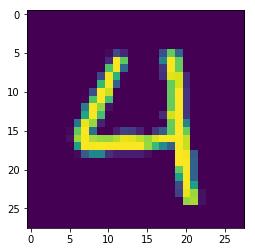

In [18]:
plt.imshow(images[0].squeeze())

In [19]:
# zobrazim si viac obrazkov
def show_images(images, labels, rows,cols):
    fig, axes = plt.subplots(rows, cols , figsize=(cols , rows))
    #vsetky podgrafy su teraz ulozene v tejto premennej
    #tato premenna je dvojrozmerne pole, ktore obsahuje spolu 6x10 podobrazkov
    for idx in range(0,rows*cols):
        ridx = idx//cols #celociselne delenie
        cidx = idx % cols
    
        ax = axes[ridx, cidx]
        ax.imshow(images[idx].squeeze())
        ax.set_title("{}".format(labels[idx]))
        ax.axis("off")
    plt.show()
    return fig
    
        

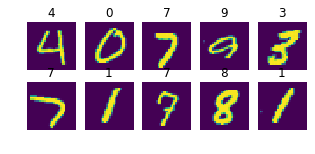

In [20]:
fig = show_images(images,labels, rows=2, cols=5)

In [22]:
# aktualne ale mam k cislu priradeny label. To nechcem, pretoze ja chcem mat na vystupe pravdepodobnosť od 0-9
x = np.zeros(10)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
x[0]=1.0
print(x)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
# vytvorim si funkciu, ktora mi tieto labels zmeni na vektory
def conv_to_vectors(labels):
    #na zaciatok si vytvorim docasne pole new_labels a bude to prazdne pole
    new_labels = []
    for label in labels:
        x = np.zeros(10)
        x[label]=1.0
        new_labels.append(x)
    new_labels=torch.from_numpy(np.vstack(new_labels))
    return new_labels

In [27]:
labels = conv_to_vectors(labels)
labels[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=torch.float64)